In [20]:
import whetlab
import pandas as pd
import numpy as np
from scipy import ndimage
from sklearn import cross_validation
from sklearn import decomposition as decomp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
np.set_printoptions(suppress=True, precision=3)
from blurd.util import *
from scipy import stats
from sklearn.metrics import precision_score, recall_score
import seaborn as sns
%pylab inline
sns.set_style("ticks")

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
#####################################
# What experiment are we looking at?
#####################################

filename = "/Users/Alex/Dropbox/Science/Side Projects/Blood Testing/data.pandas"
seed = 0
n_folds = 5

In [3]:
# Load it up
sdf = pd.read_pickle(filename)

# Create a unique tag for each patient
sdf['patient'] = sdf.sample+"-"+sdf.date

# Select only good vials
sdf = sdf[sdf.good == True]

# Fill in the micro/hypo calls based on these criteria (AND THEN MOVE TO THE EXTRACTION NOTEBOOK)
# ALL THESE INDICES ARE TO CALL THE MICRO/HYPOCHROMIC ANEMIC POPULATION
hypo_idx = sdf['%Hypo'] >= 3.9
anemic_woman_idx = (sdf['Age'] > 15) & (sdf['Sex'] == "F") & (sdf.HGB < 12.0) & hypo_idx
anemic_man_idx = (sdf['Age'] > 15) & (sdf['Sex'] == "M") & (sdf.HGB < 13.0) & hypo_idx
anemic_infant_idx = (sdf['Age'] < 5) & (sdf.HGB < 11.0) & hypo_idx
anemic_child_idx = (sdf['Age'] >= 5) & (sdf['Age'] < 15) & (sdf.HGB < 11.5) & hypo_idx
anemic_population_idx = anemic_woman_idx | anemic_man_idx | anemic_infant_idx | anemic_child_idx
sdf.blood_type.values[np.argwhere(anemic_population_idx)[()]] = 'anemic'
sdf.blood_type.values[np.argwhere(anemic_population_idx == False)[()]] = 'normal'

# Gather the blood-type for prediction
int_y = sdf['blood_type'].values.copy()
int_y[int_y == 'anemic'] = 1
int_y[int_y == 'normal'] = 0
int_y = int_y.astype('int32')
sdf['int_blood_type'] = int_y

# Get the patients
patients = sdf.patient.unique()

# For each patient, get the blood-type
patient_blood_type = []
for patient in patients:
    patient_blood_type.append(sdf[sdf.patient == patient].blood_type.values[0])
patient_blood_type = np.array(patient_blood_type)

# Hold out a final test set
np.random.seed(0)
train_patient_idx, test_patient_idx = list(cross_validation.StratifiedShuffleSplit(patient_blood_type, n_iter=1, test_size=1.0/n_folds))[0]

train_patients = patients[train_patient_idx]
test_patients = patients[test_patient_idx]
all_train_idx = np.array([p in train_patients for p in sdf.patient])
all_test_idx = np.array([p in test_patients for p in sdf.patient])
train_patient_blood_type = patient_blood_type[train_patient_idx]
test_patient_blood_type = patient_blood_type[test_patient_idx]

# Divide the training patients into the remaining folds for K-fold cross-validated training.
# This will help us guard a little against overfitting.
trainvalidation_folds = list(cross_validation.StratifiedKFold(train_patient_blood_type, n_folds=n_folds-1))

In [14]:
# # Get the best result, and all results
# scientist = whetlab.Experiment(name='Classifying IDA (patient-based folds)')
# job = scientist.best()
job = {u'C': 31.751086256664323,
 u'centrifugation_time': 2,
 u'n_dimensions': 23,
 u'nphase': 3,
 u'penalty': u'l2',
 u'reduc_method': 3,
 u'softwindow_mean': 46.21489821548001,
 u'softwindow_variance': 26.09274863908755}

In [4]:
def classify(job, sdf, train_patients, train_patient_idx, validation_patient_idx):
    """
    job is the whetlab params
    sdf is the DataFrame
    train_patients are the patient names that we're training on (includes validation in folds)
    train_idx is what we're training on
    validate_idx is what we're testing on
    """
    # Prepare the blood parameter index
    all_data = np.vstack(sdf.data.values)
    blood_param = sdf['int_blood_type'].values
    blood_param_idx = ((sdf.run_time == 2*int(job['centrifugation_time'])) & (sdf.ida == "IDA%d" % job['nphase'])).values

    # Apply a soft window to the data (better than cropping)
    window = stats.norm.pdf(np.arange(all_data.shape[1]), loc=job['softwindow_mean'], scale=job['softwindow_variance'])
    window /= window.max()
    cropped_data = all_data*window[None,:]

    # NOTE: Doing the unsupervised step on all the training data.
    # Other options include:
    # - all data (it's unsupervised so should be fine)
    # - all training data, irrespective of blood parameters (e.g. include all centrifugation times together)
    unsupervised_train_idx = np.array([p in train_patients for p in sdf.patient])
    all_train_data = cropped_data[unsupervised_train_idx & blood_param_idx].copy()
    reduc_method = ['raw','pca','nmf','kernelpca'][job['reduc_method']]
    if reduc_method == "raw":
        processed_data = ndimage.zoom(cropped_data,(1,job['n_dimensions']/cropped_data.shape[1]))
    elif reduc_method == "nmf":
        preprocessor = decomp.NMF(job['n_dimensions']).fit(all_train_data)
        processed_data = preprocessor.transform(cropped_data)
    elif reduc_method == "pca":
        preprocessor = decomp.PCA(job['n_dimensions']).fit(all_train_data)
        processed_data = preprocessor.transform(cropped_data)
    elif reduc_method == "kernelpca":
        preprocessor = decomp.KernelPCA(job['n_dimensions'],'rbf',gamma=1.0).fit(all_train_data)
        processed_data = preprocessor.transform(cropped_data)

    # Prepare the indices for this fold (only using the training patients)
    train_idx = blood_param_idx & np.array([p in train_patients[train_patient_idx] for p in sdf.patient])
    validation_idx = blood_param_idx & np.array([p in train_patients[validation_patient_idx] for p in sdf.patient])

    # Get the data and labels
    train_data = processed_data[train_idx]
    validation_data = processed_data[validation_idx]
    train_y = blood_param[train_idx]
    validation_y = blood_param[validation_idx]

    assert len(train_data) == len(train_y), "Unequal data and label sizes"
    assert len(validation_data) == len(validation_y), "Unequal data and label sizes"

    # Train a model
    learner = LogisticRegression(penalty=job['penalty'], C=job['C'], fit_intercept=True).fit(train_data,train_y) 
    scores = learner.decision_function(validation_data).ravel()
    pred_y = learner.predict(validation_data)
    return validation_y, pred_y, scores, np.argwhere(train_idx)[()], np.argwhere(validation_idx)[()]

In [5]:
spdf = pd.DataFrame([sdf[sdf.patient==p].iloc[0] for p in patients]).reset_index()

In [6]:
pdf = spdf.copy()
pdf['Age'] = pd.cut(spdf['Age'], [0, 5,15,60], right=True, labels=[5,15,60])

In [7]:
# ================================================
# These discrepancies still need to be resolved
# ================================================

print len(spdf[spdf.Sex == "F"])
print len(spdf[spdf.Sex == "M"])
print len(spdf[(pdf.Age == 5) & (pdf.Sex == "F")]) # JWK has 29
print len(spdf[(pdf.Age == 5) & (pdf.Sex == "M")]) # JWK has 36
print len(spdf[(pdf.Age == 15) & (pdf.Sex == "F")]) # JWK has 18
print len(spdf[(pdf.Age == 15) & (pdf.Sex == "M")]) # JWK has 22
print len(spdf[(pdf.Age == 60) & (pdf.Sex == "F")]) # JWK has 27
print len(spdf[(pdf.Age == 60) & (pdf.Sex == "M")]) # JWK has 20

74
78
34
42
16
19
24
17


### Hypochromia  

the condition of having hypochromic RBCs
```
%hypo ≥ 3.9%
```

### Micro/Hypo Anemia  

micro/hypo anemia—the condition of having hypochromic RBCs and low HGB
```
%hypo ≥ 3.9% and when 
HGB < 12.0 g/dl for females over 15 yrs, 
HGB < 13.0 g/dl for males over 15 yrs, 
HGB < 11.0 g/dl for children under 5 yrs, and 
HGB < 11.5 g/dl for children 5 to 15 yrs, and 
```

### IDA  
IDA as micro/hypo anemia when 
```
Micro/Hypo anemia AND
%micro/%hypo < 1.5
```

### β-thalassemia trait
β-thalassemia when

```
Micro/Hypo anemia AND
%micro/%hypo > 1.5
```

### Performance for calling different anemia subtypes

In [8]:
this_sdf = sdf.copy()
hypochromia_idx = (this_sdf['%Hypo'] >= 3.9).values.astype('int32')
microhypoanemia_idx = this_sdf['int_blood_type'].values
ida_idx = (this_sdf['%Micro/%Hypo Ratio'] <= 1.5).values & microhypoanemia_idx
betatt_idx = (this_sdf['%Micro/%Hypo Ratio'] > 1.5).values & microhypoanemia_idx

In [9]:
# NOTE NOTE NOTE
# The patient stratification is done based on a micro/hypo anemia diagnosis! 


Hypochromia
auc: 0.98 (0.97,1.00)
Confusion Matrix:
[[2776  177]
 [ 185 2851]]

Micro/Hypo Anemia
auc: 0.95 (0.87,0.97)
Confusion Matrix:
[[3177  372]
 [ 485 1965]]

IDA
auc: 0.92 (0.87,0.94)
Confusion Matrix:
[[3214  482]
 [ 519 1791]]


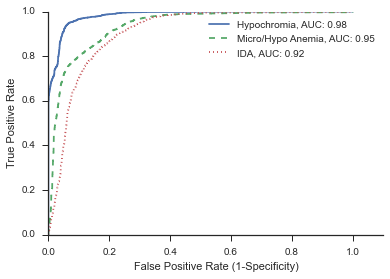

In [24]:
colors = sns.color_palette(n_colors=3)
linestyles = ['solid','dashed','dotted']
this_sdf = sdf.copy()
figure()
curves = {}
for idiagnosis,(this_diagnosis_idx, name) in enumerate(zip([hypochromia_idx, microhypoanemia_idx, ida_idx], 
                                    ["Hypochromia", "Micro/Hypo Anemia", "IDA"])):
    this_sdf = sdf.copy()
    this_sdf['int_blood_type'] = this_diagnosis_idx

    aucs = []
    validation_idxs = []
    true_ys = []
    pred_ys = []
    all_scores = []
    for train, validate in cross_validation.StratifiedShuffleSplit(train_patient_blood_type, n_iter=50, test_size=0.5):
        true_y, pred_y, scores, train_idx, validation_idx = classify(job, this_sdf, train_patients, train, validate)
        auc = roc_auc_score(true_y, scores)
        aucs.append(auc)
        validation_idxs.extend(validation_idx)
        true_ys.extend(true_y)
        pred_ys.extend(pred_y)
        all_scores.extend(scores)

    print("\n"+name)
    print(u"auc: %2.2f (%2.2f,%2.2f)"%tuple(np.percentile(aucs, [50,5,95])))
    print "Confusion Matrix:"
    print confusion_matrix(true_ys, pred_ys)
    true_ys = np.array(true_ys)
    pred_ys = np.array(pred_ys)
    all_scores = np.array(all_scores)
    validation_idxs = np.array(validation_idxs)
    
    fpr, tpr, _ = roc_curve(true_ys, all_scores)
    plot(fpr, tpr, label=name+ ", AUC: %2.2f" % np.percentile(aucs,50), color=colors[idiagnosis], linestyle=linestyles[idiagnosis])
    ylabel("True Positive Rate")
    xlabel("False Positive Rate (1-Specificity)")
    sns.despine()
    xlim(0,1.1)
    
    curves[name] = {}
    curves[name]['fpr'] = fpr
    curves[name]['tpr'] = tpr
    
legend()

In [ ]:
for idiagnosis,(this_diagnosis_idx, name) in enumerate(zip([hypochromia_idx, microhypoanemia_idx, ida_idx], 
                                    ["Hypochromia", "Micro/Hypo Anemia", "IDA"])):
    this_sdf = sdf.copy()
    this_sdf['int_blood_type'] = this_diagnosis_idx

    aucs = []
    validation_idxs = []
    true_ys = []
    pred_ys = []
    all_scores = []
    true_y, pred_y, scores, train_idx, validation_idx = classify(job, this_sdf, patients, train_patient_idx, test_patient_idx)
    auc = roc_auc_score(true_y, scores)
    print(auc)
    aucs.append(auc)
    validation_idxs.extend(validation_idx)
    true_ys.extend(true_y)
    pred_ys.extend(pred_y)
    all_scores.extend(scores)

In [ ]:
auc = roc_auc_score(true_y, scores)
print(auc)
fpr, tpr, _ = roc_curve(true_y, scores)
plot(fpr, tpr, label=name+ ", AUC: %2.2f" % np.percentile(aucs,50), color=colors[idiagnosis])

In [ ]:
# out = np.zeros((5974,6))
# headers = curves.keys()
# print headers
# for i,key in enumerate(headers):
#     out[:,i*2] = curves[key]['fpr'][:len(out)]
#     out[:,i*2+1] = curves[key]['tpr'][:len(out)]
# headers = ["IDA FPR", "IDA TPR", "Hypochromia FPR", "Hypochromia TPR", "Micro/Hypo FPR", "Micro/Hypo TPR"]
# np.savetxt("/Users/Alex/Desktop/roc-curves.csv", out, delimiter=',', header=",".join(headers))

### Performance for different Age/Sex groups

In [ ]:
woman_idx = np.argwhere((sdf['Age'] > 15) & (sdf['Sex'] == "F")).ravel()
man_idx = np.argwhere((sdf['Age'] > 15) & (sdf['Sex'] == "M")).ravel()
child_idx = np.argwhere((sdf['Age'] >= 5) & (sdf['Age'] < 15)).ravel()
infant_idx = np.argwhere((sdf['Age'] < 5)).ravel()
all_woman_idx = np.argwhere(sdf['Sex'] == "F").ravel()
all_man_idx = np.argwhere(sdf['Sex'] == "M").ravel()
all_adult_idx = np.argwhere(sdf['Age'] > 15).ravel()

In [ ]:
train_patients

In [ ]:
aucs = []
validation_idxs = []
true_ys = []
pred_ys = []
all_scores = []
n_folds = 500
for train, validate in cross_validation.StratifiedShuffleSplit(train_patient_blood_type, n_iter=n_folds, test_size=0.5):
    true_y, pred_y, scores, train_idx, validation_idx = classify(job, this_sdf, train_patients, train, validate)
    auc = roc_auc_score(true_y, scores)
    aucs.append(auc)
    validation_idxs.append(validation_idx.ravel())
    true_ys.append(true_y)
    pred_ys.append(pred_y)
    all_scores.append(scores)
validation_idxs = np.array(validation_idxs)
true_ys = np.array(true_ys)
pred_ys = np.array(pred_ys)
all_scores = np.array(all_scores)

In [ ]:
validation_idxs

In [ ]:
np.array([((v in pop_idx) & (v in disease_ind)) for v in validation_idxs[i]])

In [ ]:
test_patient_idx

In [83]:
i = 0
for disease_name, disease_idx in zip(["Hypochromia", "Micro/Hypo", "IDA"], [hypochromia_idx,microhypoanemia_idx,ida_idx]):
    print "%s" % disease_name
    print "="*50
    disease_ind = np.argwhere(disease_idx).ravel()
    for pop_idx, pop_name in zip([woman_idx, man_idx, child_idx, infant_idx, all_woman_idx, all_man_idx, all_adult_idx], 
                                 ["Women Over 15", "Men Over 15", "Between 5 and 15", "Younger Than 5", 
                                  "All Women", "All Men", "All Over 15"]):

        pop_auc = []
        for i in range(n_folds):
            this_idx = np.array([((v in pop_idx) & (v in disease_ind)) for v in validation_idxs[i]])
            try:
                pop_auc.append(roc_auc_score(true_ys[i][this_idx], all_scores[i][this_idx]))
            except:
                continue
    
        try:
            print pop_name + " AUC: %2.2f (%2.2f, %2.2f)" % tuple(np.percentile(pop_auc, [50,10,90]))
        except:
            continue

Hypochromia
Women Over 15 AUC: 0.86 (0.50, 1.00)
Between 5 and 15 AUC: 0.88 (0.60, 1.00)
Younger Than 5 AUC: 0.70 (0.55, 0.82)
All Women AUC: 0.75 (0.61, 0.88)
All Men AUC: 0.67 (0.50, 0.81)
All Over 15 AUC: 0.83 (0.55, 1.00)
Micro/Hypo
Younger Than 5 AUC: 0.60 (0.37, 0.83)
All Women AUC: 0.83 (0.50, 1.00)
All Men AUC: 0.48 (0.29, 0.64)
IDA


### Performance across number of phases and centrifugation time

auc: 0.94 (0.89,0.97)
auc: 0.94 (0.89,0.97)
auc: 0.94 (0.91,0.98)
auc: 0.94 (0.88,0.97)
auc: 0.93 (0.88,0.97)
auc: 0.94 (0.89,0.97)
auc: 0.94 (0.87,0.97)
auc: 0.89 (0.81,0.94)
auc: 0.87 (0.79,0.92)
auc: 0.84 (0.77,0.89)


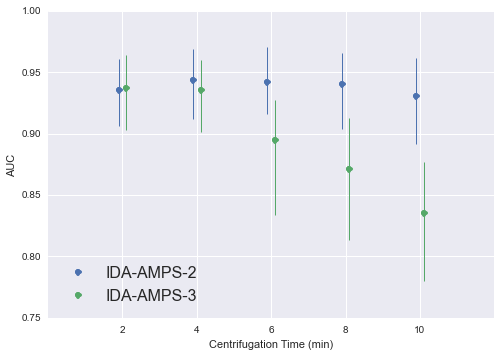

In [18]:
# Do the above cross-validation for nphase=[2,3],centrifugation_time=[2,4,6,8,10]
nphases = [2,3]
centrifugation_times = [1,2,3,4,5] # these get multiplied by two in the classification function
job_copy = dict(job)

outcomes = {}
for nphase in nphases:
    for centrifugation_time in centrifugation_times:
        this_job = dict(job)
        this_job['centrifugation_time'] = centrifugation_time
        this_job['nphase'] = nphase
        aucs = []
        for train, validate in cross_validation.StratifiedShuffleSplit(train_patient_blood_type, n_iter=500, test_size=0.5):
            true_y, pred_y, scores, train_idx, validation_idx = classify(this_job, sdf, train_patients, train, validate)
            auc = roc_auc_score(true_y, scores)
            aucs.append(auc)
        print(u"auc: %2.2f (%2.2f,%2.2f)"%tuple(np.percentile(aucs, [50,5,95])))
        outcomes[nphase,centrifugation_time] = aucs

colors = sns.color_palette(n_colors=2)
for i,nphase in enumerate(nphases):
    for centrifugation_time in centrifugation_times:
        median,lower,upper = np.percentile(outcomes[nphase,centrifugation_time], [50,10,90])
        if centrifugation_time == 1:
            label = "IDA-AMPS-%d"%nphase
        else:
            label = None
        plot(centrifugation_time+i*0.1-0.05, median, 'o', color=colors[nphase-2], label=label)
        vlines(centrifugation_time+i*0.1-0.05, lower, upper, linewidth=1, color=colors[nphase-2])
xlim(0,6)
xticks([1,2,3,4,5], [2,4,6,8,10])
xlabel("Centrifugation Time (min)")
ylabel("AUC")
legend(loc='lower left', fontsize=16)

In [24]:
# Print out 5,50,95 CI for 

# phase, run_time, 5, 50, 95 CI
headers = ["nphase", "run_time", "median", "10thpercent", "90thpercent"]
print ",".join(headers)
for nphase in nphases:
    for centrifugation_time in centrifugation_times:
        median,lower,upper = np.percentile(outcomes[nphase,centrifugation_time], [50,10,90])
        print "%s, %d, %2.2f, %2.2f, %2.2f" % (nphase, centrifugation_time*2, lower, median, upper)

nphase,run_time,median,10thpercent,90thpercent
2, 2, 0.91, 0.94, 0.96
2, 4, 0.91, 0.94, 0.97
2, 6, 0.92, 0.94, 0.97
2, 8, 0.90, 0.94, 0.97
2, 10, 0.89, 0.93, 0.96
3, 2, 0.90, 0.94, 0.96
3, 4, 0.90, 0.94, 0.96
3, 6, 0.83, 0.89, 0.93
3, 8, 0.81, 0.87, 0.91
3, 10, 0.78, 0.84, 0.88


In [19]:
print 'hi'

hi


### How awful are we with IDA vs bTT?

In [327]:
# Load it up
sdf = pd.read_pickle(filename)

# Create a unique tag for each patient
sdf['patient'] = sdf.sample+"-"+sdf.date

# Select only good vials
sdf = sdf[sdf.good == True]

# Fill in the micro/hypo calls based on these criteria (AND THEN MOVE TO THE EXTRACTION NOTEBOOK)
# ALL THESE INDICES ARE TO CALL THE MICRO/HYPOCHROMIC ANEMIC POPULATION
hypochromia_idx = (sdf['%Hypo'] >= 3.9).values.astype('int32')
anemic_woman_idx = (sdf['Age'] > 15) & (sdf['Sex'] == "F") & (sdf.HGB < 12.0) & hypochromia_idx
anemic_man_idx = (sdf['Age'] > 15) & (sdf['Sex'] == "M") & (sdf.HGB < 13.0) & hypochromia_idx
anemic_infant_idx = (sdf['Age'] < 5) & (sdf.HGB < 11.0) & hypochromia_idx
anemic_child_idx = (sdf['Age'] >= 5) & (sdf['Age'] < 15) & (sdf.HGB < 11.5) & hypochromia_idx
microhypoanemia_idx = (anemic_woman_idx | anemic_man_idx | anemic_infant_idx | anemic_child_idx).values.astype('int32')

ida_idx = (sdf['%Micro/%Hypo Ratio'] <= 1.5).values & microhypoanemia_idx
betatt_idx = (sdf['%Micro/%Hypo Ratio'] > 1.5).values & microhypoanemia_idx

blood_type = sdf['blood_type'].values
orig_blood_type = blood_type.copy()
blood_type[:] = 'normal'
blood_type[np.argwhere(ida_idx)] = 'ida'
blood_type[np.argwhere(betatt_idx)] = 'tt'
# blood_type[hypochromia_idx] = 'hypochromia'
# blood_type[microhypoanemia_idx] = 'microhypo'

sdf['blood_type'] = blood_type

# df = pd.DataFrame([sdf[sdf.patient==patient].iloc[0] for patient in sdf.patient.unique()])
# df['blood_type'].value_counts()

In [399]:
# For just this section! Filter out everything that's not IDA or tt
sdf = sdf[sdf.blood_type!='normal']
sdf['int_blood_type'] = label_binarize(sdf.blood_type.values, ['ida', 'tt']).ravel()

In [400]:
# For each patient, get the blood-type
ida_patient_blood_type = []
patients = sdf.patient.unique()
for patient in patients:
    ida_patient_blood_type.append(sdf[sdf.patient == patient].blood_type.values[0])
ida_patient_blood_type = np.array(ida_patient_blood_type)

In [ ]:
aucs = []
validation_idxs = []
true_ys = []
pred_ys = []
all_scores = []
for train, validate in cross_validation.StratifiedShuffleSplit(train_patient_blood_type, n_iter=50, test_size=0.5):
    true_y, pred_y, scores, train_idx, validation_idx = classify(job, this_sdf, train_patients, train, validate)
    auc = roc_auc_score(true_y, scores)
    aucs.append(auc)
    validation_idxs.extend(validation_idx)
    true_ys.extend(true_y)
    pred_ys.extend(pred_y)
    all_scores.extend(scores)


In [402]:
aucs = []
validation_idxs = []
true_ys = []
pred_ys = []
all_scores = []
for train, validate in cross_validation.StratifiedShuffleSplit(ida_patient_blood_type, n_iter=50, test_size=0.5):
    true_y, pred_y, scores, train_idx, validation_idx = classify(job, sdf, patients, train, validate)
    try:
        auc = roc_auc_score(true_y, scores)
        aucs.append(auc)
        validation_idxs.extend(validation_idx)
        true_ys.extend(true_y)
        pred_ys.extend(pred_y)
        all_scores.extend(scores)
    except:
        continue
    
print(u"auc: %2.2f (%2.2f,%2.2f)"%tuple(np.percentile(aucs, [50,5,95])))
fpr, tpr, _ = roc_curve(true_ys, all_scores)

auc: 0.41 (0.20,0.56)


In [ ]:
fpr, tpr, _ = roc_curve(true_ys, all_scores)
plot(fpr, tpr, label="IDA vs TT, AUC: %2.2f" % np.percentile(aucs,50))
ylabel("True Positive Rate")
xlabel("False Positive Rate (1-Specificity)")
legend(loc='upper left', fontsize=14)